# Предиктор результатов футбольных матчей

In [92]:
#importing
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn # эти строки должны идти перед импортом sklearn
patch_sklearn()                     # для ускорения работы

from sklearn.model_selection    import train_test_split, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics            import accuracy_score, RocCurveDisplay, precision_recall_fscore_support
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import LabelBinarizer
from sklearn.tree               import DecisionTreeClassifier
from sklearn.ensemble           import RandomForestClassifier
from sklearn.inspection         import permutation_importance

from catboost import CatBoostClassifier, Pool, metrics

import shap

from itertools import cycle

from joblib import dump

n_jobs = -1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Обзор данных

In [93]:
data = pd.read_csv("data.csv")
data.head()

,idmatch,odds_open_win1,odds_open_draw,odds_open_win2,vi_win_home,vi_win_away,vi_nolose_home,vi_nolose_away,vi_over25_home,vi_over25_away,...,team2_away_xgpower_03_draw_xga90index,team2_away_xgpower_03_draw_xgsubxgaindex,team2_away_xgpower_03_cop_xg90index,team2_away_xgpower_03_cop_xga90index,team2_away_xgpower_03_cop_xgsubxgaindex,team2_away_xgpower_03_com_xg90index,team2_away_xgpower_03_com_xga90index,team2_away_xgpower_03_com_xgsubxgaindex,result_finish_match,result_total_match
0,39231,2.53,3.15,3.02,2.255,-4.318,19.259,-3.855,-41.798,-10.410,...,0.98,0.40,2.13,4.88,0.44,0.55,2.79,0.20,2.0,0.0
1,39232,2.16,3.26,3.66,-13.230,-29.496,4.164,-47.122,-43.926,-4.662,...,1.23,0.36,0.00,0.00,0.00,0.51,1.34,0.38,1.0,0.0
2,39233,2.35,3.16,3.31,-35.270,-1.048,-17.721,-2.781,8.467,-6.808,...,0.87,0.31,0.00,0.17,0.00,0.00,0.00,0.00,3.0,1.0
3,39235,2.50,3.25,2.97,17.593,27.970,1.079,10.260,-27.452,-23.279,...,1.99,0.05,0.00,0.00,0.00,0.18,0.80,0.22,3.0,1.0
4,45425,2.15,3.49,3.46,19.656,-22.231,-8.999,-8.685,7.560,-7.321,...,0.64,1.45,3.35,1.40,2.40,0.73,2.48,0.29,1.0,1.0


In [94]:

with open("raw_data_info.txt", mode='w') as df_info:
    data.info(verbose=True, show_counts=True, buf=df_info)
print('\nБаланс классов\n')
print(data['result_finish_match'].value_counts(), '\n')
print(data['result_total_match'].value_counts())



Баланс классов

1.0    24763
3.0    17585
2.0    15099
Name: result_finish_match, dtype: int64 

0.0    29307
1.0    28140
Name: result_total_match, dtype: int64


Классы более или менее сбалансированны.

## Предобработка

Оставим для обучения и теста только данные, удовлетворяющие условию `selection` (см. код ниже).  Nan-строки долой. На тест выделяем 20% данных, остальное -- обучение.

Увеличим обучающий датасет вдвое, продублировав все строки таким образом, чтобы столбцы, отвечающие за одни и те же параметры для разных команд, поменялись местами. У одинаковых матчей одинаковые id, поэтому для кросс-валидации используем GroupKFold, чтобы никакие два матча не попали одновременно в обучающую и валидационную выборки.

In [95]:
# Для решения задачи пригодными считаем лишь данные, для которых коэффициенты "odds_open_tm25" > 1.8 и "odds_open_tb25" > 1.8
selection = (data["odds_open_tm25"] > 1.8) & (data["odds_open_tb25"] > 1.8)

data_selected = data[selection].dropna()
data_selected.shape

(13359, 624)

In [96]:
# Делим на трейн и тест
y_finish = data_selected['result_finish_match'].astype(int) # на это пока не смотрим
y_result = data_selected['result_total_match'].astype(int) 
X = data_selected.drop(['result_finish_match', 'result_total_match'], axis=1)
X.iloc[1:, :].astype('float32', copy=False)

X_train, X_test, y_train, y_test = train_test_split(X, y_result, test_size=0.2, random_state=42, shuffle=True, stratify=y_finish)

In [97]:
# Дублируем данные и переставляем местами пары столбцы следующих видов: 
# "...-2" и "...", 
# "team1..." и "team2...", 
# "...win1" и "...win2" 

def swap(feature_name_1, feature_names_2, train_copy):
    X_train_copy[feature_name_1], X_train_copy[feature_names_2] = X_train_copy[feature_names_2], X_train_copy[feature_name_1]


X_train_copy = X_train.copy(deep=True)
swap('odds_open_win1', 'odds_open_win2', X_train_copy)

for name_2 in X_train_copy.filter(like="-2").columns:  # колонки с паттерном "-2"
    name_1 = ''.join(name_2.split("-2"))  # композиция split и join выделяет из строки подстроку без "-2"
    swap(name_1, name_2, X_train_copy)

for name_2 in X_train_copy.filter(like="team2").columns:  # колонки с паттерном "team2"
    tmp = ''.join(name_2.split("team2"))
    name_1 = 'team1' + tmp  # композиция split и join выделяет из строки подстроку без "team2", слева приписывается "team1"
    swap(name_1, name_2, X_train_copy)


X_train = pd.concat((X_train, X_train_copy))
y_train = pd.concat((y_train, y_train))

In [98]:
groups_train, groups_test = X_train['idmatch'], X_test['idmatch']
X_train.drop('idmatch', axis=1, inplace=True)
X_test.drop('idmatch', axis=1, inplace=True)

X_train.shape, y_train.shape

((21374, 621), (21374,))

In [99]:
# для визуализации результатов сделаем бинаризацию классов: 
# label_binarizer = LabelBinarizer().fit(y_train)
# y_onehot_test = label_binarizer.transform(y_test)
# y_onehot_test.shape  # (n_samples, n_classes)

## Вспомогательные функции

In [100]:
def find_best_model(model, X_train, y_train, groups_train, params_grid, scoring, n_iter=0):
    """
    Функция подбора гиперпараметров
    """

    global n_jobs

    if n_iter:
        search = RandomizedSearchCV(
            model, params_grid, n_iter=n_iter,
            scoring=scoring,
            cv=StratifiedGroupKFold(n_splits=5),
            n_jobs=n_jobs
        )
    else:
        search = GridSearchCV(
        model, params_grid,
        scoring=scoring,
        cv=StratifiedGroupKFold(n_splits=5),
        n_jobs=n_jobs
        )

    search.fit(X_train, y_train, groups=groups_train)

    # Print the best hyperparameters
    print("Best hyperparameters:", search.best_params_)

    # Print the best score
    print("Best cross-val score:", search.best_score_)

    return search.best_estimator_


# def display_roc_curves(probas, auc, target_names):
#     """
#     Отображает микро-усреднённую ROC кривую, а так же ROC-кривые по каждому из классов
#     :probas: предсказанные вероятности классов
#     :auc: Area Under the Curve ROC (macro)
#     :target_names: имена классов
#     """

#     fig, ax = plt.subplots(figsize=(6, 6))

#     fpr_micro, tpr_micro, _ = roc_curve(y_onehot_test.ravel(), probas.ravel())
#     plt.plot(
#         fpr_micro,
#         tpr_micro,
#         label=f"micro-average ROC curve (AUC = {auc:.2f})",
#         color='m',
#         linestyle=":",
#         linewidth=3,
#     )

#     n_classes = probas.shape[1]
#     colors = cycle(["aqua", "darkorange", "cornflowerblue"])
#     for class_id, color in zip(range(n_classes), colors):
#         RocCurveDisplay.from_predictions(
#             y_onehot_test[:, class_id],
#             probas[:, class_id],
#             name=f"ROC curve for {target_names[class_id]}",
#             color=color,
#             ax=ax,
#             plot_chance_level=(class_id == 2),
#         )

#     plt.axis("square")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
#     plt.legend()
#     plt.grid()
#     plt.show()


def test_and_save(estimator, name, X_test, y_test, groups_test):
    """
    Прогоняет обученную модель по тестовой выборке и сохраняет результаты в файл с именем "name_results.csv" 
    в виде таблицы со столбцами: idmatch, истинные классы, предсказания, коэффициенты уверенности (2 столбца), вероятности классов, 
    а также сохраняет саму модель.
    """

    y_pred = np.ravel(estimator.predict(X_test))
    probas = estimator.predict_proba(X_test)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy  = accuracy_score(y_test, y_pred)

    print("Accuracy: ", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:   ", round(recall, 3))
    print("F1:       ", round(f1, 3))

    table = pd.DataFrame({
        'result_finish_match': y_test,
        'result_finish_match_prediction': y_pred,
        'proba_0': probas[:, 0],
        'proba_1': probas[:, 1],
        }, index=groups_test)
    
    # сохраняем таблицу с результатами теста
    table.to_csv(name + '_results.csv')
    
    # сохраняем модель
    dump(estimator, name + '_estimator.joblib')

    # display_roc_curves(probas, roc_auc, ('win_1', 'draw', 'win_2'))

    return table
    

## Логистическая регрессия

In [101]:
log_reg = LogisticRegression(
    penalty='l2',
    solver='newton-cholesky',
    n_jobs=n_jobs
)

params = {"C": np.logspace(-6, 4, 20)}

print("Логистическая регрессия (метрика f1)")
log_reg_best = find_best_model(log_reg, X_train, y_train, groups_train, params, scoring='f1')

Логистическая регрессия (метрика f1)
Best hyperparameters: {'C': 0.6158482110660255}
Best cross-val score: 0.49737447890055175


In [102]:
log_reg_results = test_and_save(log_reg_best, 'logistic_1', X_test, y_test, groups_test)

Accuracy:  0.523
Precision: 0.523
Recall:    0.507
F1:        0.515


invalid value encountered in cast


**Вывод:** модель едва лучше рандомайзера. Метрика `precision` немного больше чем `recall`, значит в матрице ошибок `FP` < `FN`, т. е. модель слегка более уверенна в предсказании 0, чем в предсказании 1.

## Решающее дерево

In [103]:
params = {
    'max_depth': range(5, 15, 3),
    'min_samples_split' : range(400, 1001, 20)
}

tree = DecisionTreeClassifier(random_state=42)

print("Решающее дерево (метрика accuracy)")
tree_best = find_best_model(tree, X_train, y_train, groups_train, params, scoring='f1')

Решающее дерево (метрика accuracy)
Best hyperparameters: {'max_depth': 14, 'min_samples_split': 1000}
Best cross-val score: 0.5001325784926058


In [104]:
tree_results = test_and_save(tree_best, 'tree_1', X_test, y_test, groups_test)

Accuracy:  0.51
Precision: 0.508
Recall:    0.573
F1:        0.538


invalid value encountered in cast


**Вывод:** не лучше лог. регрессии

## Случайный лес

In [105]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=n_jobs, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42, warm_start=True)

In [106]:
forest_results = test_and_save(forest, 'forest_1', X_test, y_test, groups_test)

Accuracy:  0.501
Precision: 0.501
Recall:    0.455
F1:        0.477


invalid value encountered in cast


**Вывод:** практически как лог. регрессия.

Важности признаков в модели случайного леса.

In [107]:
def visualize_feature_importances(model_name, importances_mean, importances_std=None, features=None):

    max = importances_mean.max()

    model_importances = pd.Series(importances_mean, index=features)

    fig, ax = plt.subplots(figsize=(17, 5))
    model_importances.plot.bar(yerr=importances_std, ax=ax)
    ax.set_title(model_name)
    ax.set_ylabel(f"Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

In [108]:
perm_imps_forest = permutation_importance(
    forest, X_test, y_test, n_repeats=5, random_state=43, n_jobs=-1
)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


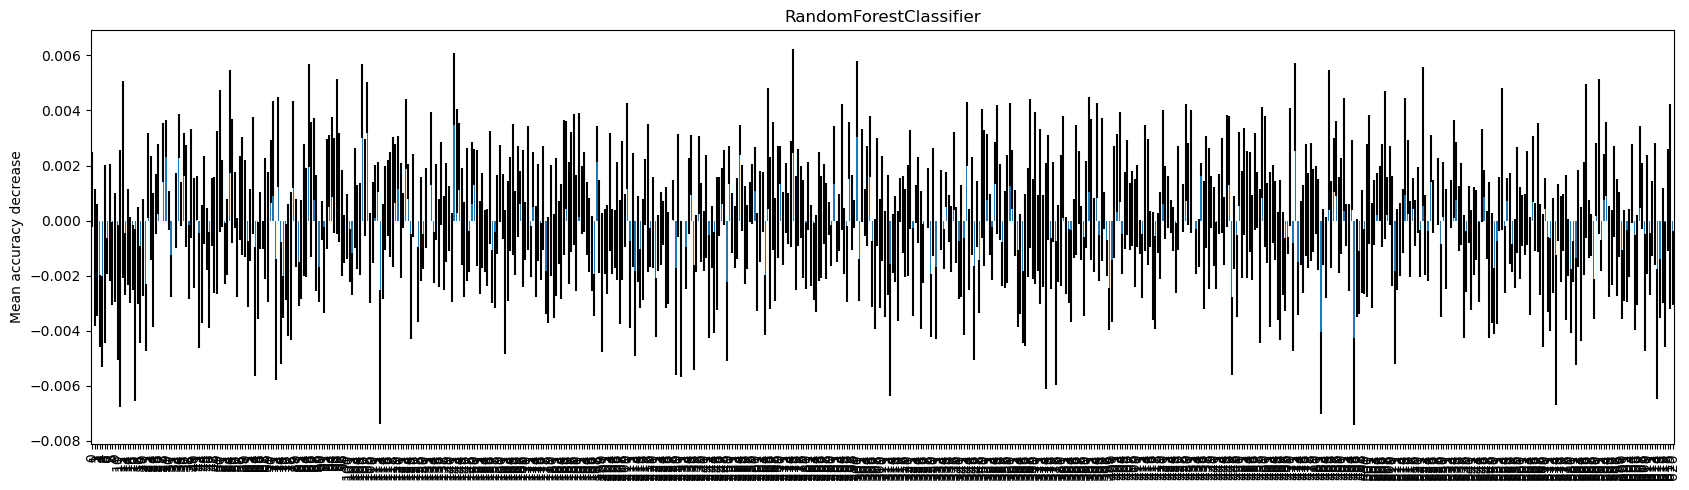

In [109]:
visualize_feature_importances(
    'RandomForestClassifier',
    perm_imps_forest.importances_mean, 
    perm_imps_forest.importances_std
)

Видно, что есть признаки, для которых `mean_accuracy_decrease` отрицательно. Т. е. Удаление этих признаков из датасета может повысить точность. Удалим все, для которых важность не превосходит 0.3 от максимального значения.

In [121]:
good_features = X_test.columns[perm_imps_forest.importances_mean + perm_imps_forest.importances_std > perm_imps_forest.importances_mean.max() * 0.5]

X_test_small, X_train_small = X_test[good_features], X_train[good_features]

X_test_small.shape, X_train_small.shape

((2672, 177), (21374, 177))

In [122]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=n_jobs, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train_small, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42, warm_start=True)

In [123]:
forest_results = test_and_save(forest, 'forest_2', X_test_small, y_test, groups_test)

Accuracy:  0.512
Precision: 0.513
Recall:    0.468
F1:        0.489


invalid value encountered in cast


**Вывод:** ощутимого эффекта нет.

## CatBoost

In [113]:
# создадим пуллы
train_pool = Pool(X_train, y_train)
test_pool  = Pool(X_test,  y_test)

In [114]:
CB_model = CatBoostClassifier(
    iterations=10000,
    loss_function="CrossEntropy",
    use_best_model=True,
    eval_metric=metrics.F1(),
    verbose=250,
    early_stopping_rounds=250
    )

CB_model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.4250128	test: 0.4237211	best: 0.4237211 (0)	total: 54.6ms	remaining: 9m 6s
250:	learn: 0.6527375	test: 0.4932163	best: 0.5004016 (215)	total: 13.6s	remaining: 8m 48s
500:	learn: 0.7589422	test: 0.5052879	best: 0.5060713 (467)	total: 26.8s	remaining: 8m 27s
750:	learn: 0.8345734	test: 0.4906103	best: 0.5066667 (510)	total: 39.9s	remaining: 8m 11s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.5066666667
bestIteration = 510

Shrink model to first 511 iterations.


In [115]:
CB_results = test_and_save(CB_model, 'catboost', X_test, y_test, groups_test)

Accuracy:  0.529
Precision: 0.531
Recall:    0.484
F1:        0.507


invalid value encountered in cast


**Вывод:** всего 5 итераций, и модель начала переобучаться. Очень мало, это сильно ставит под сомнение идею вообще пытаться что-то предсказывать. Точность примерно как у логистической регрессии.

Посчитаем и выведем в файл `catboost_importances.txt` важности признаков в порядке убывания, а также визуализируем 50 самых "важных".

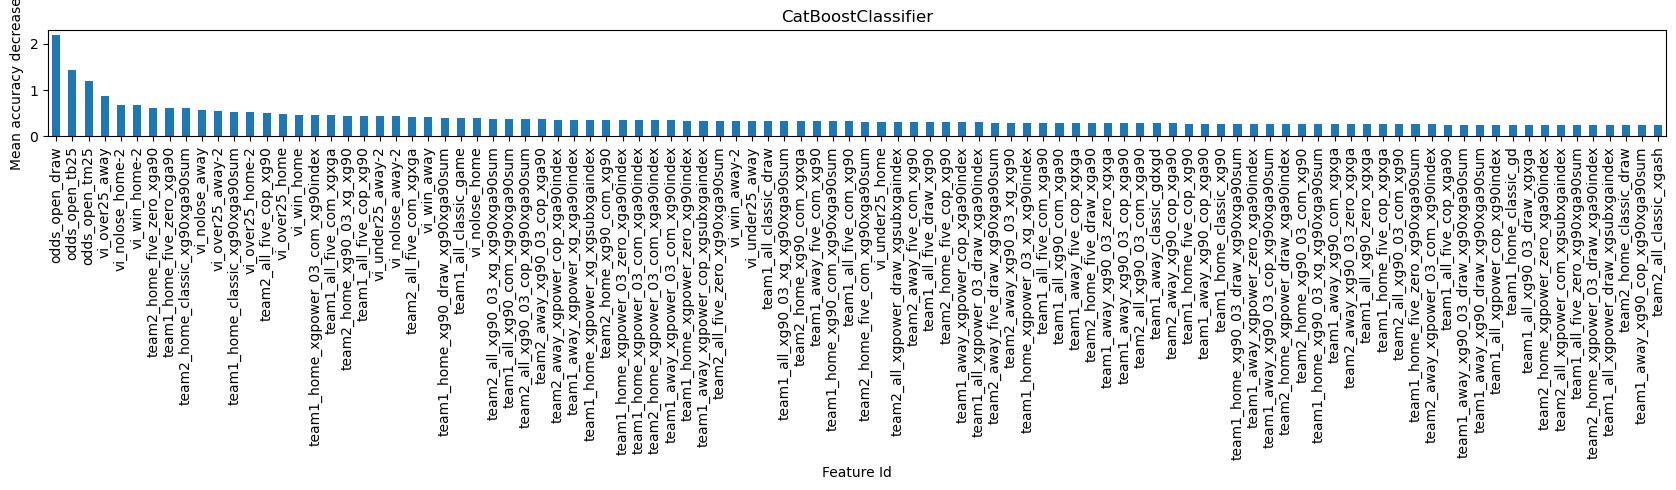

In [116]:
feature_inportances = CB_model.get_feature_importance(train_pool, prettified=True)
feature_inportances.to_csv('catboost_importances.txt')

# сколько признаков визуализировать
n_features_show = 100
# из DataFrame делаем Series
feature_inportances_pdSeries = pd.Series(
    feature_inportances['Importances'].iloc[:n_features_show].values, 
    index=feature_inportances['Feature Id'].iloc[:n_features_show]
    )

visualize_feature_importances(
    'CatBoostClassifier', 
    feature_inportances_pdSeries, 
    features=feature_inportances_pdSeries.index)

**Вывод:** для этого таргета существенно меньше признаков влияют на предсказание. Основной вклад вносят `odds_open_tm25` и `odds_open_tb25`.

Для наглядной интерпретации работы модели может быть полезно применить методы из [этой](https://uproger.com/obyasnite-lyubuyu-model-mashinnogo-obucheniya-na-python-s-pomoshhyu-shap/) статьи. Ниже изображён пример для матча c `id` 32815.

In [117]:
print("Истина:", y_test.iloc[1])
print("Предсказание", CB_model.predict(X_test.iloc[1, :]))
print('"Псевдо-вероятность":', CB_model.predict(X_test.iloc[1, :], prediction_type="RawFormulaVal"))
print("Вероятности:         ", CB_model.predict_proba(X_test.iloc[1, :]))

Истина: 1
Предсказание 0
"Псевдо-вероятность": -0.106328219441068
Вероятности:          [0.52655704 0.47344296]


In [118]:
explainer = shap.Explainer(CB_model)
shap_values = explainer(X_test)

In [119]:
shap.initjs()
print('Class "win1"')
shap.plots.force(shap_values[1, :])

Class "win1"


**Пояснение:** чёрные числа -- то что на самом деле предсказывает модель, перед тем, как специальная функция преобразует их к вероятностям, то есть засовывает в интервал от 0 до 1. Например, первый график означает, что в предсказание 0.17 (читай "в вероятность 0.39") наибольший вклад внесли признаки, подписаннные синим. Цвет вроде бы ничего особо не означает. Подробнее по ссылке выше. Не знаю, насколько это полезно, но если что, то такие штуки можно нарисовать для каждого матча. 

**Вывод:** CatBoost действительно сработал лучше, но не сильно, как я и предполагал. Итоговая точность составила почти 0.41. Из графика с ROC-кривыми следует, что в предсказании ничьей модель менее уверенна, чем в предсказаниях побед, хотя разница не велика.